Check if saving and everything else has been correctly done after run the script for prestim later none filter on eCortex

In [157]:
import mne
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from mne.datasets import sample
from mne.decoding import cross_val_multiscore, LinearModel, GeneralizingEstimator, Scaler, \
                         Vectorizer
from sklearn.model_selection import StratifiedKFold, cross_val_score, StratifiedShuffleSplit, \
                                    RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC

import argparse

import pickle

# Set args

In [158]:
# class arguments():
#     SAVE_EPOCH_ROOT = '../../data/version5.2/preprocessed/epochs/aft_ICA_rej/'
#     SAVE_RESULT_ROOT = '../../results/temp_gen/eCortex/'
#     cond_filter ='none' # {none,non_symm}
#     cond_block ='later' #{early,later}
#     cond_time = 'prestim' #{prestim,poststim}
#     cond_decoding = 'removeevoked' #{none,removeevoked,resampled}
#     subj_num = 1
#     applyBaseline_bool = 'False'
#     pre_tmin = -0.4
#     pre_tmax = 0.05
#     post_tmin = 0.05
#     post_tmax = 0.45
#     num_classes = 2
#     normalization_type = 'normal'# {normal,lstmPaper}
#     gen_rand_perm = 0
#     null_max_iter = 10000
#     loop_null_iter = 5
#     gen_decoder_scores = 1
#     n_splits = 100
#     random_state = 42 
#     max_iter = 10000
#     n_jobs = 100
#     scoring = 'roc_auc'
#     folder='noneFilter_PrePost_decodremoveevoked_bslineFalse_100k/'
#     SAVE_RESULT_ROOT = SAVE_RESULT_ROOT + folder
    
# args = arguments()

In [159]:
class arguments:
    def __init__(self, cond_block, cond_decoding, applyBaseline_bool, n_splits):
        self.cond_block = cond_block #'later' #{early,later}
        self.cond_decoding = cond_decoding #'removeevoked' #{none,removeevoked,resampled}
        self.applyBaseline_bool = applyBaseline_bool #'False'
        self.n_splits = n_splits#100

        self.SAVE_EPOCH_ROOT = '../../data/version5.2/preprocessed/epochs/aft_ICA_rej/'
        self.SAVE_RESULT_ROOT = '../../results/temp_gen/eCortex/'
        self.cond_filter ='none' # {none,non_symm}
        self.cond_time = 'prestim' #{prestim,poststim}
        self.subj_num = 1
        self.pre_tmin = -0.4
        self.pre_tmax = 0.05
        self.post_tmin = 0.05
        self.post_tmax = 0.45
        self.num_classes = 2
        self.normalization_type = 'normal'# {normal,lstmPaper}
        self.gen_rand_perm = 0
        self.null_max_iter = 10000
        self.loop_null_iter = 5
        self.gen_decoder_scores = 1
        self.random_state = 42 
        self.max_iter = 10000
        self.n_jobs = 1
        self.scoring = 'roc_auc'
        self.folder='noneFilter_PrePost_decod%s_bsline%s%s/' %(cond_decoding, \
                                                       applyBaseline_bool, \
                                                       n_splits)
        self.SAVE_RESULT_ROOT = self.SAVE_RESULT_ROOT + self.folder
        print(self.SAVE_RESULT_ROOT)


In [122]:
if args.applyBaseline_bool:
    filename_epoch = args.SAVE_EPOCH_ROOT + \
                     'epochs_sec_applyBaseline_subj%s-afterRejICA-epo.fif' \
                      %args.subj_num
else:
    filename_epoch = args.SAVE_EPOCH_ROOT + \
                     'epochs_sec_subj%s-afterRejICA-epo.fif' \
                     %args.subj_num
epochs_orig = mne.read_epochs(filename_epoch, proj=True, preload=True,
                              verbose=None)
epochs = epochs_orig.copy()
subset = epochs['pred']['non'].copy()
subset = subset.pick_types(eeg=True)
if (args.cond_decoding=='removeevoked'):
    # REMOVE EVOKED RESP.
    subset.subtract_evoked()    # remove evoked response
elif (args.cond_decoding=='resampled'):
    # RESAMPLE
    subset = subset.resample(args.n_resampling, npad='auto')
else:
    pass
##==========================================================================
if subset['Block==7'].metadata.Ptrn_Type.values.shape[0]>0:
   main_ptrn = subset['Block==7'].metadata.Ptrn_Type.values[0]
else:
   main_ptrn = subset['Block==8'].metadata.Ptrn_Type.values[0]
##==========================================================================
if args.cond_block=='early': #block 3-6
    subset = subset['Block<7'].copy()
    subset = subset['Block>2'].copy()
elif args.cond_block=='later':#block 7-10
    subset = subset['Block<11'].copy()
    subset = subset['Block>6'].copy()
##==========================================================================
subset = subset.crop(tmin=-0.45, tmax=0.45)
print('Shape of data is\n :')
print(subset._data.shape)

Reading ../../data/version5.2/preprocessed/epochs/aft_ICA_rej/epochs_sec_applyBaseline_subj1-afterRejICA-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 129) active
    Found the data of interest:
        t =    -400.00 ...    5000.00 ms
        0 CTF compensation matrices available
1197 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1197 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 16 columns
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Subtracting Evoked from Epochs
[done]


<ipython-input-122-9e1a9e889303>:31: RuntimeWarning: tmin is not in epochs time interval. tmin is set to epochs.tmin
  subset = subset.crop(tmin=-0.45, tmax=0.45)


Shape of data is
 :
(357, 129, 213)


# Plot functions

In [128]:
def smooth(y, window, mode):
    box = np.ones(window)/window
    y_smooth = np.convolve(y, box, mode=mode)
    return y_smooth

def plot_scores(scores):
    fig, ax = plt.subplots(1, 1)
    plt.tight_layout()
    im = ax.imshow(scores, interpolation='lanczos', origin='lower', cmap='RdBu_r',
                   extent=subset.times[[0, -1, 0 , -1]], vmin=0., vmax=0.6)
    ax.set_xlabel('Testing Time (s)')
    ax.set_ylabel('Training Time (s)')
    ax.set_title('Temporal generalization')
    ax.axvline(0, color='k')
    ax.axhline(0, color='k')
    ax.xaxis.set_ticks_position('bottom')
    plt.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

def plot_scores_diag(scores_diag, apply_smooth):
    if apply_smooth:
        window=50
        mode='valid'
        scores_diag = smooth(y, window, mode)
        print(subset.times.shape)
        print(y_smooth.shape)
    fig, ax = plt.subplots()
    ax.plot(subset.times, scores_diag, label='score')
    ax.axhline(.5, color='k', linestyle='--', label='chance')
    ax.set_xlabel('Times')
    ax.set_ylabel('AUC')  # Area Under the Curve
    ax.legend()
    ax.axvline(.0, color='k', linestyle='-')
    ax.set_title('Sensor space decoding')
    plt.tight_layout()
    plt.show()

# Statistical analysis

## Plot functions

In [77]:
def do_time_bin(data, indx, sbt):
    if sbt==0:
        avgs=np.zeros(len(indx))
        bs=np.array(np.split(data, indx))
        for ii in range(len(indx)):
            avgs[ii]=bs[ii].mean()
    if sbt==1:
         avgs=np.zeros([data.shape[0],len(indx)])
         aa=np.zeros(len(indx))
         for jj in range(data.shape[0]):
             bs=np.array(np.split(data[jj,:], indx))
             for ii in range(len(indx)):
                 aa[ii]=bs[ii].mean()
             avgs[jj,:]=aa
    if sbt==2:
         avgs=np.zeros([len(indx),len(indx)])
         aa=np.zeros(len(indx))
         for jj in range(data.shape[0]):
             bs1=np.array(np.split(data[jj,:], indx))
             bs2=np.array(np.split(data[:,jj], indx))
             for ii in range(len(indx)):
                 avgs[ii,:]=bs1[ii].mean()
                 avgs[:,ii]=bs2[ii].mean()

    return avgs

In [88]:
def set_fonts():
    from matplotlib.font_manager import FontProperties
    font = FontProperties()
    font.set_family('serif')
    font.set_name('Calibri')
    return font

def plot_scores_stat(diag_scores, clusts):
    font=set_fonts();
    [t_obs, clusters, clusters_pv, H0] = clusts
    # binned times
    indx=[26,51,76,101,126,151,176,201,226,251]
    
#     times=np.asarray([-0.4,-0.3,-0.2,-0.1,0.1,0.2,0.3,0.4])
    times=np.asarray([-0.4,-0.35,-0.3,-0.25,-0.2,-0.15,-0.1,0,0.05,0.15,0.2,0.25,0.3,0.35,0.4,0.45])
    extent_times=subset.times[[0, -1, 0, -1]]
    print(extent_times.shape)#4
    print(times.shape)#16
    print(diag_scores.shape)#10
    # Plot the diagonal (it's exactly the same as the time-by-time decoding above)
    fig, ax = plt.subplots()
    plt.tight_layout()
    ax.plot(times, diag_scores, label='score')
    ax.axhline(.5, color='k', linestyle='--', label='chance')
    plt.ylim([0.43,0.65])
    ax.axvline(.0, color='k', linestyle='-')

    for i_clu, clu_idx in enumerate(clusters):
        clu_idx=clu_idx[0]
        print(clu_idx)
        # unpack cluster information, get unique indices
        if clusters_pv[i_clu] <= 0.05:
            h = plt.axvspan(times[clu_idx[0]], times[clu_idx[-1] - 1],
                            color='r', alpha=0.3)
            plt.legend((h, ), ('cluster p-value < 0.05', ))
        else:
            plt.axvspan(times[clu_idx[0]], times[clu_idx[-1] - 1], color=(0.3, 0.3, 0.3),
                        alpha=0.3)

    plt.tight_layout()
    plt.xlabel('Times',  fontproperties=font, fontsize=12, fontweight='bold')
    plt.ylabel('AUC', fontproperties=font, fontsize=12, fontweight='bold')#, labelpad=16,)
    plt.title('Decoding over time', fontproperties=font, fontweight='bold', fontsize=16)

    plt.legend(fontsize=11)
    plt.tight_layout()

[-1.184 -0.784 -0.384  0.016  0.416  0.816  1.216  1.616  1.76 ]


## Statistical analysis

In [79]:
def stat_anal(scores_pck):
#     indx=[26,51,76,101,126,151,176,201]
    indx=[26,51,76,101,126,151,176,201,226,251]
    score, score_diag = scores_pck
    score_subtract = score_diag - 0.5
    
    binned_score = do_time_bin(score, indx, 2)
    binned_score_diag = do_time_bin(score_diag, indx, 0)
    binned_score_subtract = do_time_bin(score_subtract, indx, 0)
    
    print(score_subtract.shape)
#     score_subtract=score_subtract[:, np.newaxis, np.newaxis] # [:,:, np.newaxis] when added more subjects
    score_subtract=score_subtract[:, np.newaxis] # [:,:, np.newaxis] when added more subjects
    
    print(score_subtract.shape)
    t_obs, clusters, clusters_pv, H0 = mne.stats.spatio_temporal_cluster_1samp_test(score_subtract, tail=0)
    
    clust_pck = [t_obs, clusters, clusters_pv, H0]
    
    return binned_score_diag, clust_pck

# load nested list results using pickle

In [80]:
selected_subj_P1 = [1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 15, 16, \
                    42, 43, 44, 45, 47, 48, 51, 52, 53, \
                    55, 56, 57, 58, 59, 60, 61, 62, 63, 64, \
                    66, 67, 68, 69, 71, 72, 73, 74]
selected_subj_P2 = [18, 19, 20, 21, 23, 24, 26, 28, 29, 30, \
                   31, 32, 33, 34, 35, 36, 38, 39]

In [160]:
def combine_subj_scores(args, subj_p1, subj_p2):
    avgp1_sc=[]
    avgp2_sc=[]
    avgp1_diag=[]
    avgp2_diag=[]

    avgp1_sc_fit=[]
    avgp2_sc_fit=[]
    avgp1_diag_fit=[]
    avgp2_diag_fit=[]

    for subj_id in selected_subj_P1:
        main_ptrn = 1
        args.subj_num = subj_id

        fn_str_sbj='scores_timeGen_%sBlocks_%sFilter_PrePost_decod%s_bsline%s%s_Subj_%s' \
                %(args.cond_block, args.cond_filter, \
                args.cond_decoding, args.applyBaseline_bool, \
                args.n_splits, args.subj_num)

        fn_str = args.SAVE_RESULT_ROOT + 'avgP%s_' %(main_ptrn) + fn_str_sbj


        with open(fn_str, 'rb') as f:
            sc_subj_pck = pickle.load(f)

        avgp1_sc.append(sc_subj_pck[0])
        avgp1_diag.append(sc_subj_pck[1])

        avgp1_sc_fit.append(sc_subj_pck[2])
        avgp1_diag_fit.append(sc_subj_pck[3])

    for subj_id in selected_subj_P2:
        main_ptrn = 2
        args.subj_num = subj_id

        fn_str_sbj='scores_timeGen_%sBlocks_%sFilter_PrePost_decod%s_bsline%s%s_Subj_%s' \
                %(args.cond_block, args.cond_filter, \
                args.cond_decoding, args.applyBaseline_bool, \
                args.n_splits, args.subj_num)

        fn_str = args.SAVE_RESULT_ROOT + 'avgP%s_' %(main_ptrn) + fn_str_sbj


        with open(fn_str, 'rb') as f:
            sc_subj_pck = pickle.load(f)


        avgp2_sc.append(sc_subj_pck[0])
        avgp2_diag.append(sc_subj_pck[1])

        avgp2_sc_fit.append(sc_subj_pck[2])
        avgp2_diag_fit.append(sc_subj_pck[3])


    print(np.asarray(avgp1_diag).shape)
    print(np.asarray(avgp2_diag).shape)

    p1=np.asarray(avgp1_sc)
    p2=np.asarray(avgp2_sc)
    p=np.concatenate((p1, p2), axis=0)
#     avgP = np.mean(p, axis=0)

    p1d=np.asarray(avgp1_diag)
    p2d=np.asarray(avgp2_diag)
    pd=np.concatenate((p1d, p2d), axis=0)
#     avgPdiag = np.mean(pd, axis=0)

    scores_pck_p = [p, pd]
    
    return scores_pck_p

# Different conditions

## cond1

../../results/temp_gen/eCortex/noneFilter_PrePost_decodremoveevoked_bslineFalse_100k/
(37, 213)
(18, 213)
scores_timeGen_earlyBlocks_noneFilter_PrePost_decodremoveevoked_bslineFalse_100k


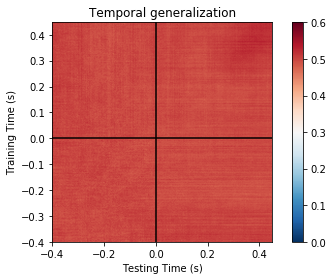

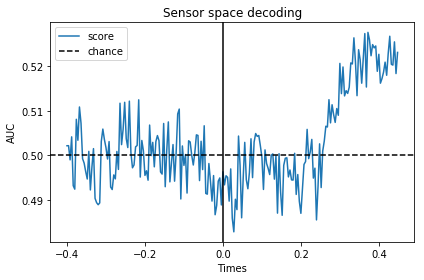

In [161]:
args = arguments('early', 'removeevoked', 'False', '_100k' )
# ------------- #
scores_pck_p_e = combine_subj_scores(args, selected_subj_P1, selected_subj_P2)
avgP_e = np.mean(scores_pck_p_e[0], axis=0)
avgPdiag_e = np.mean(scores_pck_p_e[1], axis=0)
# ------------- #
conds = 'scores_timeGen_%sBlocks_%sFilter_PrePost_decod%s_bsline%s%s' \
                %(args.cond_block, args.cond_filter, \
                args.cond_decoding, args.applyBaseline_bool, \
                args.n_splits)
# ------------- #
print(conds)
# ------------- #
plot_scores(avgP_e)
plot_scores_diag(avgPdiag_e, 0)

../../results/temp_gen/eCortex/noneFilter_PrePost_decodremoveevoked_bslineFalse_100k/
(37, 213)
(18, 213)
scores_timeGen_laterBlocks_noneFilter_PrePost_decodremoveevoked_bslineFalse_100k


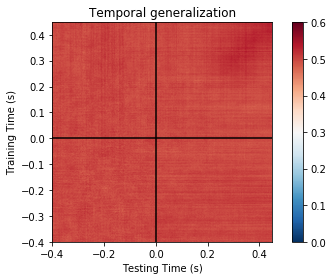

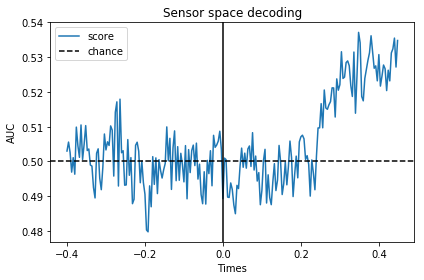

In [165]:
args = arguments('later', 'removeevoked', 'False', '_100k' )
# ------------- #
scores_pck_p_l = combine_subj_scores(args, selected_subj_P1, selected_subj_P2)
avgP_l = np.mean(scores_pck_p_l[0], axis=0)
avgPdiag_l = np.mean(scores_pck_p_l[1], axis=0)
# ------------- #
conds = 'scores_timeGen_%sBlocks_%sFilter_PrePost_decod%s_bsline%s%s' \
                %(args.cond_block, args.cond_filter, \
                args.cond_decoding, args.applyBaseline_bool, \
                args.n_splits)
# ------------- #
print(conds)
# ------------- #
plot_scores(avgP_l)
plot_scores_diag(avgPdiag_l, 0)

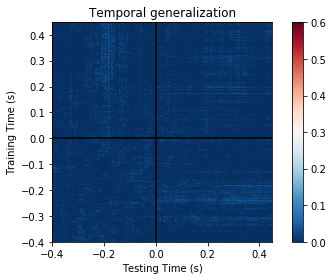

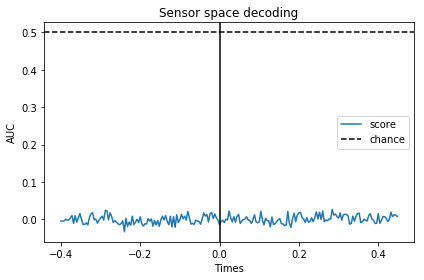

In [166]:
avgP_diff = avgP_l - avgP_e
avgPdiag_diff = avgPdiag_l - avgPdiag_e
# ------------- #
plot_scores(avgP_diff)
plot_scores_diag(avgPdiag_diff, 0)

## cond2
Not complete yet

In [180]:
args = arguments('early', 'removeevoked', 'True', '_100k' )
# ------------- #
# scores_pck_p_e = combine_subj_scores(args, selected_subj_P1, selected_subj_P2)
# avgP_e = np.mean(scores_pck_p_e[0], axis=0)
# avgPdiag_e = np.mean(scores_pck_p_e[1], axis=0)
# # ------------- #
# conds = 'scores_timeGen_%sBlocks_%sFilter_PrePost_decod%s_bsline%s%s' \
#                 %(args.cond_block, args.cond_filter, \
#                 args.cond_decoding, args.applyBaseline_bool, \
#                 args.n_splits)
# # ------------- #
# print(conds)
# # ------------- #
# plot_scores(avgP_e)
# plot_scores_diag(avgPdiag_e, 0)

../../results/temp_gen/eCortex/noneFilter_PrePost_decodremoveevoked_bslineTrue_100k/


In [178]:
# args = arguments('later', 'removeevoked', 'True', '_100k' )
# # ------------- #
# scores_pck_p_l = combine_subj_scores(args, selected_subj_P1, selected_subj_P2)
# avgP_l = np.mean(scores_pck_p_l[0], axis=0)
# avgPdiag_l = np.mean(scores_pck_p_l[1], axis=0)
# # ------------- #
# conds = 'scores_timeGen_%sBlocks_%sFilter_PrePost_decod%s_bsline%s%s' \
#                 %(args.cond_block, args.cond_filter, \
#                 args.cond_decoding, args.applyBaseline_bool, \
#                 args.n_splits)
# # ------------- #
# print(conds)
# # ------------- #
# plot_scores(avgP_l)
# plot_scores_diag(avgPdiag_l, 0)

In [179]:
# avgP_diff = avgP_l - avgP_e
# avgPdiag_diff = avgPdiag_l - avgPdiag_e
# # ------------- #
# plot_scores(avgP_diff)
# plot_scores_diag(avgPdiag_diff, 0)

## cond3
Not complete yet

In [182]:
args = arguments('early', 'removeevoked', 'False', '_3k' )
# ------------- #
# scores_pck_p_e = combine_subj_scores(args, selected_subj_P1, selected_subj_P2)
# avgP_e = np.mean(scores_pck_p_e[0], axis=0)
# avgPdiag_e = np.mean(scores_pck_p_e[1], axis=0)
# # ------------- #
# conds = 'scores_timeGen_%sBlocks_%sFilter_PrePost_decod%s_bsline%s%s' \
#                 %(args.cond_block, args.cond_filter, \
#                 args.cond_decoding, args.applyBaseline_bool, \
#                 args.n_splits)
# # ------------- #
# print(conds)
# # ------------- #
# plot_scores(avgP_e)
# plot_scores_diag(avgPdiag_e, 0)

../../results/temp_gen/eCortex/noneFilter_PrePost_decodremoveevoked_bslineFalse_3k/


In [178]:
# args = arguments('later', 'removeevoked', 'False', '_3k' )
# # ------------- #
# scores_pck_p_l = combine_subj_scores(args, selected_subj_P1, selected_subj_P2)
# avgP_l = np.mean(scores_pck_p_l[0], axis=0)
# avgPdiag_l = np.mean(scores_pck_p_l[1], axis=0)
# # ------------- #
# conds = 'scores_timeGen_%sBlocks_%sFilter_PrePost_decod%s_bsline%s%s' \
#                 %(args.cond_block, args.cond_filter, \
#                 args.cond_decoding, args.applyBaseline_bool, \
#                 args.n_splits)
# # ------------- #
# print(conds)
# # ------------- #
# plot_scores(avgP_l)
# plot_scores_diag(avgPdiag_l, 0)

In [179]:
# avgP_diff = avgP_l - avgP_e
# avgPdiag_diff = avgPdiag_l - avgPdiag_e
# # ------------- #
# plot_scores(avgP_diff)
# plot_scores_diag(avgPdiag_diff, 0)

## cond4
Not complete yet

In [182]:
args = arguments('early', 'removeevoked', 'True', '_3k' )
# ------------- #
# scores_pck_p_e = combine_subj_scores(args, selected_subj_P1, selected_subj_P2)
# avgP_e = np.mean(scores_pck_p_e[0], axis=0)
# avgPdiag_e = np.mean(scores_pck_p_e[1], axis=0)
# # ------------- #
# conds = 'scores_timeGen_%sBlocks_%sFilter_PrePost_decod%s_bsline%s%s' \
#                 %(args.cond_block, args.cond_filter, \
#                 args.cond_decoding, args.applyBaseline_bool, \
#                 args.n_splits)
# # ------------- #
# print(conds)
# # ------------- #
# plot_scores(avgP_e)
# plot_scores_diag(avgPdiag_e, 0)

../../results/temp_gen/eCortex/noneFilter_PrePost_decodremoveevoked_bslineFalse_3k/


In [178]:
# args = arguments('later', 'removeevoked', 'False', '_3k' )
# # ------------- #
# scores_pck_p_l = combine_subj_scores(args, selected_subj_P1, selected_subj_P2)
# avgP_l = np.mean(scores_pck_p_l[0], axis=0)
# avgPdiag_l = np.mean(scores_pck_p_l[1], axis=0)
# # ------------- #
# conds = 'scores_timeGen_%sBlocks_%sFilter_PrePost_decod%s_bsline%s%s' \
#                 %(args.cond_block, args.cond_filter, \
#                 args.cond_decoding, args.applyBaseline_bool, \
#                 args.n_splits)
# # ------------- #
# print(conds)
# # ------------- #
# plot_scores(avgP_l)
# plot_scores_diag(avgPdiag_l, 0)

In [179]:
# avgP_diff = avgP_l - avgP_e
# avgPdiag_diff = avgPdiag_l - avgPdiag_e
# # ------------- #
# plot_scores(avgP_diff)
# plot_scores_diag(avgPdiag_diff, 0)

## cond5

../../results/temp_gen/eCortex/noneFilter_PrePost_decodnone_bslineFalse/
(37, 213)
(18, 213)
scores_timeGen_earlyBlocks_noneFilter_PrePost_decodnone_bslineFalse


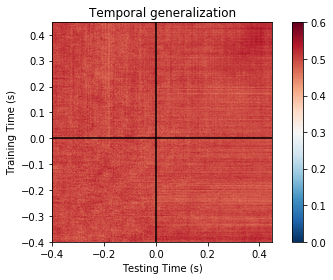

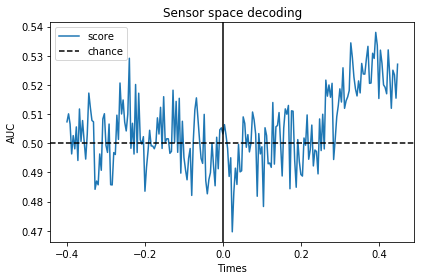

In [167]:
args = arguments('early', 'none', 'False', '' )
# ------------- #
scores_pck_p_e = combine_subj_scores(args, selected_subj_P1, selected_subj_P2)
avgP_e = np.mean(scores_pck_p_e[0], axis=0)
avgPdiag_e = np.mean(scores_pck_p_e[1], axis=0)
# ------------- #
conds = 'scores_timeGen_%sBlocks_%sFilter_PrePost_decod%s_bsline%s%s' \
                %(args.cond_block, args.cond_filter, \
                args.cond_decoding, args.applyBaseline_bool, \
                args.n_splits)
# ------------- #
print(conds)
# ------------- #
plot_scores(avgP_e)
plot_scores_diag(avgPdiag_e, 0)

../../results/temp_gen/eCortex/noneFilter_PrePost_decodnone_bslineFalse/
(37, 213)
(18, 213)
scores_timeGen_laterBlocks_noneFilter_PrePost_decodnone_bslineFalse


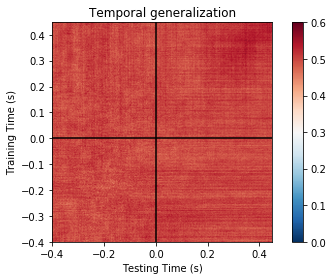

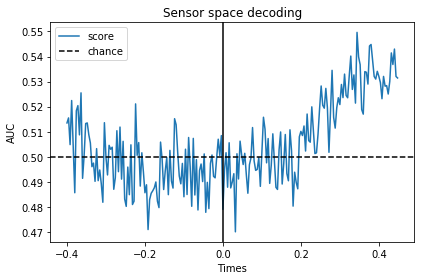

In [168]:
args = arguments('later', 'none', 'False', '' )
# ------------- #
scores_pck_p_l = combine_subj_scores(args, selected_subj_P1, selected_subj_P2)
avgP_l = np.mean(scores_pck_p_l[0], axis=0)
avgPdiag_l = np.mean(scores_pck_p_l[1], axis=0)
# ------------- #
conds = 'scores_timeGen_%sBlocks_%sFilter_PrePost_decod%s_bsline%s%s' \
                %(args.cond_block, args.cond_filter, \
                args.cond_decoding, args.applyBaseline_bool, \
                args.n_splits)
# ------------- #
print(conds)
# ------------- #
plot_scores(avgP_l)
plot_scores_diag(avgPdiag_l, 0)

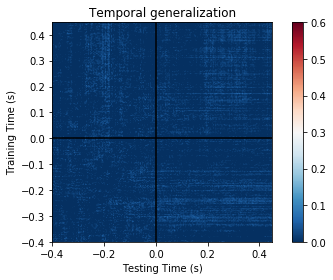

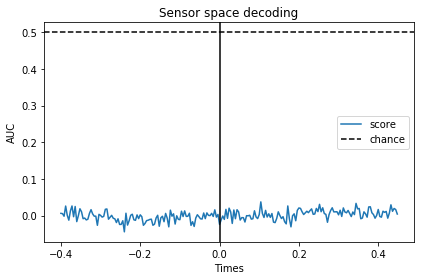

In [169]:
avgP_diff = avgP_l - avgP_e
avgPdiag_diff = avgPdiag_l - avgPdiag_e
# ------------- #
plot_scores(avgP_diff)
plot_scores_diag(avgPdiag_diff, 0)

## cond6

../../results/temp_gen/eCortex/noneFilter_PrePost_decodnone_bslineTrue/
(37, 213)
(18, 213)
scores_timeGen_earlyBlocks_noneFilter_PrePost_decodnone_bslineTrue


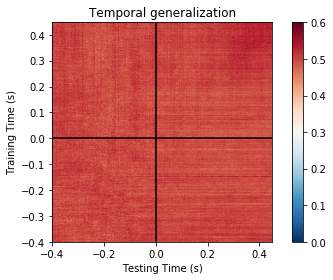

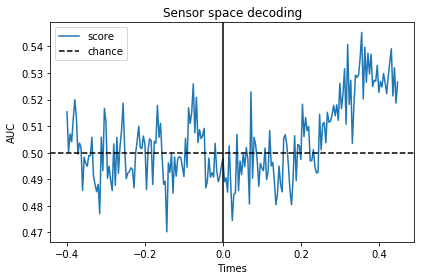

In [172]:
args = arguments('early', 'none', 'True', '' )
# ------------- #
scores_pck_p_e = combine_subj_scores(args, selected_subj_P1, selected_subj_P2)
avgP_e = np.mean(scores_pck_p_e[0], axis=0)
avgPdiag_e = np.mean(scores_pck_p_e[1], axis=0)
# ------------- #
conds = 'scores_timeGen_%sBlocks_%sFilter_PrePost_decod%s_bsline%s%s' \
                %(args.cond_block, args.cond_filter, \
                args.cond_decoding, args.applyBaseline_bool, \
                args.n_splits)
# ------------- #
print(conds)
# ------------- #
plot_scores(avgP_e)
plot_scores_diag(avgPdiag_e, 0)

../../results/temp_gen/eCortex/noneFilter_PrePost_decodnone_bslineTrue/
(37, 213)
(18, 213)
scores_timeGen_laterBlocks_noneFilter_PrePost_decodnone_bslineTrue


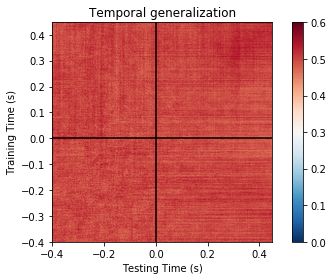

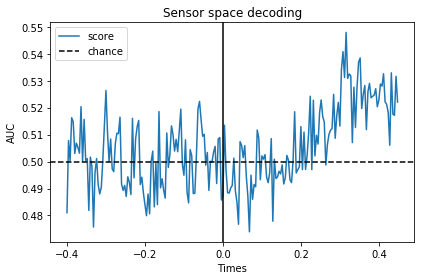

In [173]:
args = arguments('later', 'none', 'True', '' )
# ------------- #
scores_pck_p_l = combine_subj_scores(args, selected_subj_P1, selected_subj_P2)
avgP_l = np.mean(scores_pck_p_l[0], axis=0)
avgPdiag_l = np.mean(scores_pck_p_l[1], axis=0)
# ------------- #
conds = 'scores_timeGen_%sBlocks_%sFilter_PrePost_decod%s_bsline%s%s' \
                %(args.cond_block, args.cond_filter, \
                args.cond_decoding, args.applyBaseline_bool, \
                args.n_splits)
# ------------- #
print(conds)
# ------------- #
plot_scores(avgP_l)
plot_scores_diag(avgPdiag_l, 0)

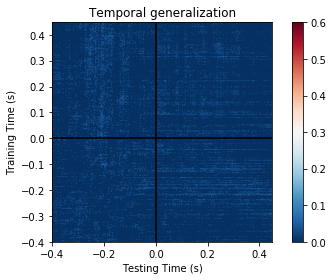

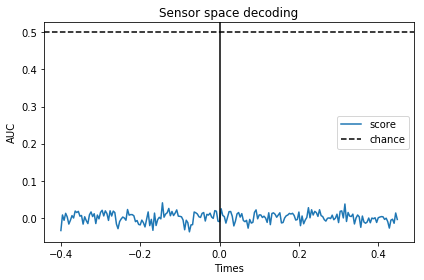

In [174]:
avgP_diff = avgP_l - avgP_e
avgPdiag_diff = avgPdiag_l - avgPdiag_e
# ------------- #
plot_scores(avgP_diff)
plot_scores_diag(avgPdiag_diff, 0)